In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time
import yfinance as yf
import csv
from gnews import GNews
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os
import dateparser
from GoogleNews import GoogleNews

In [9]:
def get_financial_reports(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)

    balance_sheet = ticker.balance_sheet
    income_statement = ticker.financials
    cash_flow = ticker.cashflow
    
    # Convert to DataFrame and transpose for better readability
    balance_sheet_df = balance_sheet.T
    income_statement_df = income_statement.T
    cash_flow_df = cash_flow.T

    # Define the directory to save the files
    save_dir = r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\Financial_reports"
    
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the DataFrames to CSV files in the specified directory
    balance_sheet_df.to_csv(os.path.join(save_dir, f'{ticker_symbol}_balance_sheet.csv'))
    income_statement_df.to_csv(os.path.join(save_dir, f'{ticker_symbol}_income_statement.csv'))
    cash_flow_df.to_csv(os.path.join(save_dir, f'{ticker_symbol}_cash_flow.csv'))

    print(f'Financial reports for {ticker_symbol} have been saved to CSV files in {save_dir}.')

get_financial_reports('AAPL')
get_financial_reports('AMZN')

Financial reports for AAPL have been saved to CSV files in C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\Financial_reports.
Financial reports for AMZN have been saved to CSV files in C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\Financial_reports.


In [10]:
def fetch_news(ticker, start_date, end_date, limit=100):
    google_news = GNews()
    search = google_news.get_news(ticker)
    
    news_data = []
    for article in search[:limit]:
        headline = article.get('title', 'No Title')
        link = article.get('url', 'No URL')
        summary = article.get('description', 'No Description')
        published_date_str = article.get('published date', None)
        
        if published_date_str:
            published_date = dateparser.parse(published_date_str)
            if published_date:
                published_date = published_date.date()
            else:
                published_date = 'No Date'
        else:
            published_date = 'No Date'
        
        news_data.append({
            'headline': headline,
            'summary': summary,
            'link': link,
            'published_date': published_date  # Add published_date to the dictionary
        })
    
    if news_data:
        keys = news_data[0].keys()
        # Define the directory to save the files
        save_dir = r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\news"
        
        # Ensure the directory exists
        os.makedirs(save_dir, exist_ok=True)
        
        # Save the CSV files in the specified directory
        file_path = os.path.join(save_dir, f'{ticker}_news.csv')
        with open(file_path, 'w', newline='', encoding='utf-8') as output_file:
            dict_writer = csv.DictWriter(output_file, fieldnames=keys)
            dict_writer.writeheader()
            dict_writer.writerows(news_data)
    else:
        print(f'No news data found for {ticker}')
        
    return news_data

# Fetch news for Amazon and Apple
amzn_news = fetch_news("Amazon", "2010-01-01", "2024-01-01")
aapl_news = fetch_news("Apple", "2010-01-01", "2024-01-01")

# Convert to DataFrame for better visualization
amzn_news_df = pd.DataFrame(amzn_news)
aapl_news_df = pd.DataFrame(aapl_news)

print("Amazon News")
print(amzn_news_df)

print("\nApple News")
print(aapl_news_df)

Amazon News
                                             headline  \
0   The Best Patio and Garden Deals in Amazon's Ou...   
1   Amazon delivery driver reportedly leaves packa...   
2   Amazon Prime Day 2024: Everything we know, inc...   
3   13 Amazon Best-Selling Maxi Dresses, All Under...   
4   Amazon gets FAA approval allowing it to expand...   
..                                                ...   
95  ‘Generation’ Duo Set Marching Band Show at Ama...   
96  Google, Amazon, Apple lobby group opposes Indi...   
97  Amazon Orders Young Sherlock Holmes Series Sta...   
98  Lauren Anderson Expands Remit At Amazon After ...   
99  38 best Amazon Memorial Day sales 2024 - CNN U...   

                                              summary  \
0   The Best Patio and Garden Deals in Amazon's Ou...   
1   Amazon delivery driver reportedly leaves packa...   
2   Amazon Prime Day 2024: Everything we know, inc...   
3   13 Amazon Best-Selling Maxi Dresses, All Under...   
4   Amazon gets FA

In [11]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return "Negative"
    else:
        return 'Neutral'

# Define the paths to the CSV files
amzn_news_path = r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\news\Amazon_news.csv"
aapl_news_path = r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\news\Apple_news.csv"

# Read the CSV files into DataFrames
amzn_news_df = pd.read_csv(amzn_news_path)
aapl_news_df = pd.read_csv(aapl_news_path)

# Apply sentiment analysis to the 'summary' column and create a new 'Sentiment' column
amzn_news_df['Sentiment'] = amzn_news_df['summary'].apply(analyze_sentiment)
aapl_news_df['Sentiment'] = aapl_news_df['summary'].apply(analyze_sentiment)

# Save the updated DataFrames back to the CSV files
amzn_news_df.to_csv(amzn_news_path, index=False)
aapl_news_df.to_csv(aapl_news_path, index=False)

# Print the sentiment analysis results
print("Amazon News Sentiment Analysis:")
print(amzn_news_df['Sentiment'].value_counts())

print("\nApple News Sentiment Analysis:")
print(aapl_news_df['Sentiment'].value_counts())

Amazon News Sentiment Analysis:
Sentiment
Positive    86
Negative    10
Neutral      4
Name: count, dtype: int64

Apple News Sentiment Analysis:
Sentiment
Neutral     45
Positive    35
Negative    20
Name: count, dtype: int64


In [31]:
amzn_stock = yf.download("AMZN", start='2010-01-01', end='2024-01-01')
aapl_stock = yf.download("AAPL", start='2010-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [13]:
def calculate_moving_averages(df, window):
    df[f"SMA_{window}"] = df['Close'].rolling(window=window).mean()
    return df

amzn_stock = calculate_moving_averages(amzn_stock, 50)
amzn_stock = calculate_moving_averages(amzn_stock, 200)
aapl_stock = calculate_moving_averages(amzn_stock, 50)
aapl_stock = calculate_moving_averages(amzn_stock, 200)

In [14]:
def calculate_volatility(df, window):
    df['Volatility'] = df['Close'].rolling(window=window).std()
    return df

amzn_stock = calculate_volatility(amzn_stock, 30)
aapl_stock = calculate_volatility(aapl_stock, 30)

In [15]:
def calculate_rsi(df, window):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0,0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0,0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

amzn_stock = calculate_rsi(amzn_stock, 14)
aapl_stock = calculate_rsi(aapl_stock, 14)

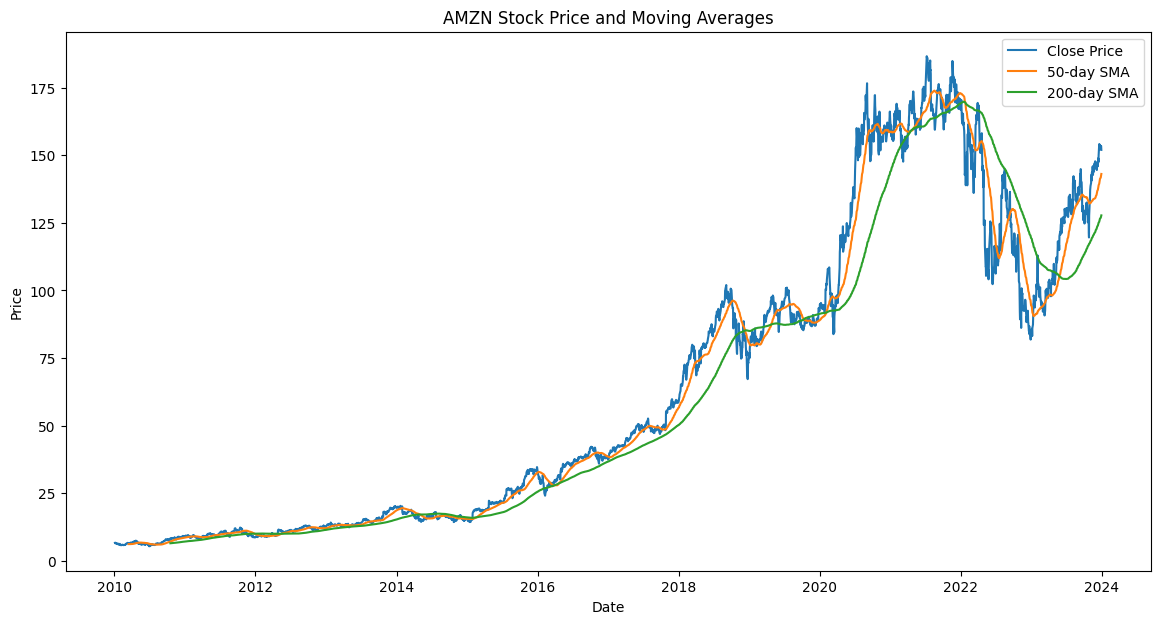

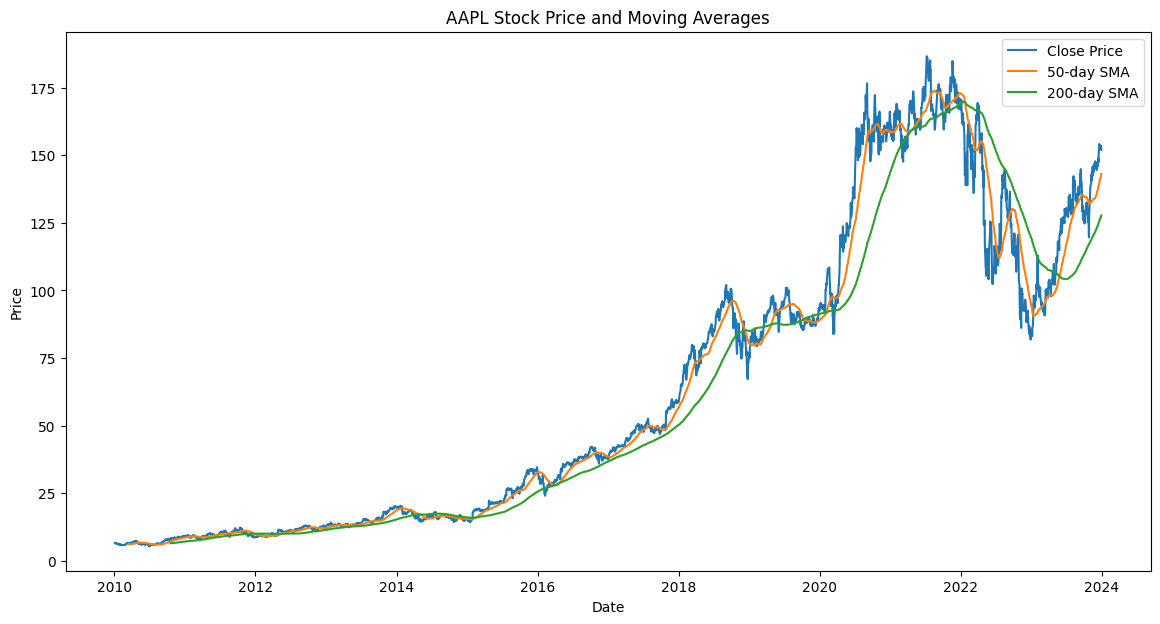

In [16]:
def plot_stock_data (df, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['SMA_50'], label='50-day SMA')
    plt.plot(df['SMA_200'], label='200-day SMA')
    plt.title(f'{ticker} Stock Price and Moving Averages')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

plot_stock_data(amzn_stock, 'AMZN')
plot_stock_data(aapl_stock, 'AAPL')

In [32]:
print(amzn_stock)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04    6.812500    6.830500    6.657000    6.695000    6.695000   
2010-01-05    6.671500    6.774000    6.590500    6.734500    6.734500   
2010-01-06    6.730000    6.736500    6.582500    6.612500    6.612500   
2010-01-07    6.600500    6.616000    6.440000    6.500000    6.500000   
2010-01-08    6.528000    6.684000    6.451500    6.676000    6.676000   
...                ...         ...         ...         ...         ...   
2023-12-22  153.770004  154.350006  152.710007  153.419998  153.419998   
2023-12-26  153.559998  153.979996  153.029999  153.410004  153.410004   
2023-12-27  153.559998  154.779999  153.119995  153.339996  153.339996   
2023-12-28  153.720001  154.080002  152.949997  153.380005  153.380005   
2023-12-29  153.100006  153.889999  151.029999  151.940002  151.940002   

               Volume  
Date         

In [33]:
# Sort the dataframes by date for merge_asof

amzn_stock['Date'] = pd.to_datetime(amzn_stock['Date'])
aapl_stock['Date'] = pd.to_datetime(aapl_stock['Date'])

amzn_stock = amzn_stock.sort_values('Date')
amzn_news_df = amzn_news_df.sort_values('published_date')
aapl_stock = aapl_stock.sort_values('Date')
aapl_news_df = aapl_news_df.sort_values('published_date')

amzn_news_df['published_date'] = pd.to_datetime(amzn_news_df['published_date'], errors='coerce')
aapl_news_df['published_date'] = pd.to_datetime(aapl_news_df['published_date'], errors='coerce')


amzn_news_df.to_csv(amzn_news_path, index=False)
aapl_news_df.to_csv(aapl_news_path, index=False)


amzn_combined = pd.merge(amzn_stock, amzn_news_df[['published_date', 'Sentiment']], left_on='Date', right_on='published_date', how='left')
aapl_combined = pd.merge(aapl_stock, aapl_news_df[['published_date', 'Sentiment']], left_on='Date', right_on='published_date', how='left')
# Print the head of the combined data to verify
print("Combined Data for Amazon:")
print(amzn_combined.head())
print("Combined Data for Apple:")
print(aapl_combined.head())



KeyError: 'Date'

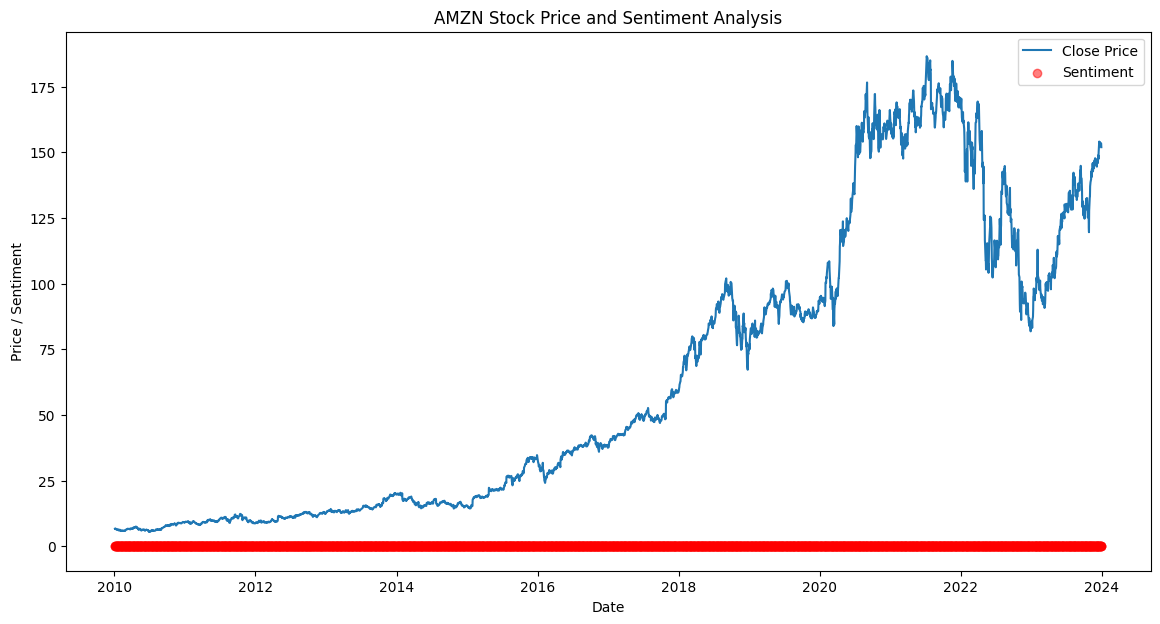

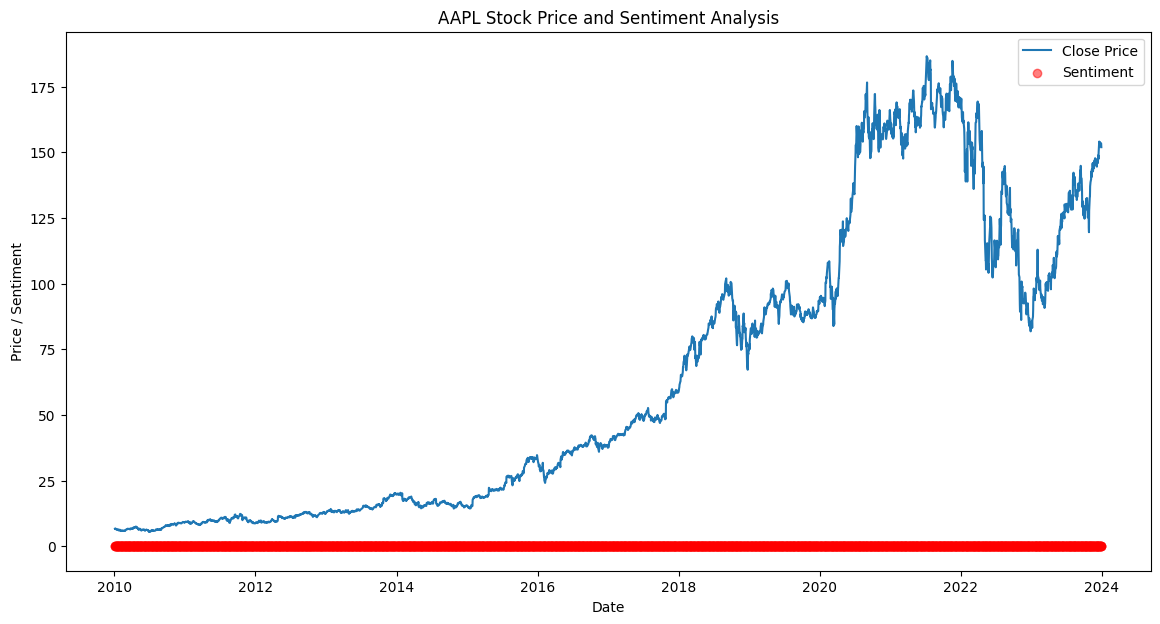

In [15]:
def analyze_sentiment_impact(df, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.scatter(df.index, df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else (-1 if x == 'Negative' else 0)), color='red', label='Sentiment', alpha=0.5)
    plt.title(f'{ticker} Stock Price and Sentiment Analysis')
    plt.xlabel('Date')
    plt.ylabel('Price / Sentiment')
    plt.legend()
    plt.show()

# Analyze sentiment impact for Amazon
analyze_sentiment_impact(amzn_combined, 'AMZN')

# Analyze sentiment impact for Apple
analyze_sentiment_impact(aapl_combined, 'AAPL')